# Introduction to data Science. Exercise 2

## Step 0: prepare data set

In [89]:
import pandas as pd
import numpy as np
import folium as fol
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as ms
import unittest
import re
from sklearn.model_selection import TimeSeriesSplit
from fbprophet import Prophet
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


### Clean up data like in previous exercise

In [2]:
def create_date_columns(frame,date_column):
    frame['YEAR']    = date_column.dt.year
    frame['DAY']     = date_column.dt.dayofyear
    frame['WEEK']    = date_column.dt.weekofyear
    frame['MONTH']   = date_column.dt.month
    frame['HOUR']    = date_column.dt.hour
    frame['WEEKDAY'] = date_column.dt.dayofweek
    return frame

In [3]:
#Function to match a reg expr. and replace the whole string with new value 
def ReplaceMatchingValue(prev,new,column):
    matchVal = re.compile("^"+prev+".*",re.I)
    column = column.apply(lambda x: re.sub(matchVal,new,x,re.IGNORECASE))
    return column

In [142]:
# Read data
data_st = pd.read_csv('example_sprit_cut_station.csv', sep=";")
data_pr = pd.read_csv('example_sprit_cut_prices.csv', sep=";")
#Drop duplicates
data_st.drop_duplicates(inplace=True)
data_pr.drop_duplicates(inplace=True)
#Merge both data
data = pd.merge(data_pr,data_st,left_on='STID',right_on= 'ID',how='inner')
data.drop(columns=['ID'], inplace= True)
#Drop irrelevant columns
to_drop_st = ['VERSION','VERSION_TIME','HOUSE_NUMBER','PUBLIC_HOLIDAY_IDENTIFIER',
              'CHANGED', 'STREET', 'POST_CODE', 'PLACE']
data.drop(to_drop_st,inplace=True,axis=1)
#Delimit data to ranges of prices 
data.drop(data[(data.E5>2000)|(data.E5<1000)].index,inplace=True,axis=0)
data.drop(data[(data.E10>1800)|(data.E10<1000)].index,inplace=True,axis=0)
data.drop(data[(data.DIESEL>1800)|(data.DIESEL<800)].index,inplace=True,axis=0)
#Convert to euro unit
data['E10'] = data['E10'].apply(lambda x:  x/1000)
data['E5'] = data['E5'].apply(lambda x:  x/1000)
data['DIESEL'] = data['DIESEL'].apply(lambda x:  x/1000)
#Drop rows with empty Brand Values and 'not active'
data.dropna(subset=['BRAND'], inplace=True)
data.drop(data[(data.NAME=='nicht mehr aktiv')].index, inplace=True,axis=0)
#Grouping same brands with slightly different name
data['BRAND'] = ReplaceMatchingValue("auto zotz","AUTO ZOTZ",data['BRAND'])
data['BRAND'] = ReplaceMatchingValue("supermarkt","Supermarkt Tankstelle",data['BRAND'])
data['BRAND'] = ReplaceMatchingValue("frei","Frei Tankstelle",data['BRAND'])
data['BRAND'] = ReplaceMatchingValue("total","Total",data['BRAND'])
data['BRAND'] = ReplaceMatchingValue("sb","SB",data['BRAND'])
#Create date columns
data['DATE_CHANGED'] =pd.to_datetime(data.DATE_CHANGED)
data = create_date_columns(data,data.DATE_CHANGED)

In [48]:
data.head()

,STID,E5,E10,DIESEL,DATE_CHANGED,NAME,BRAND,LAT,LNG,YEAR,DAY,WEEK,MONTH,HOUR,WEEKDAY
0,01bf5a06-4248-43a5-9524-56123fa3ab2f,1.589,1.549,1.389,2014-10-02 05:22:01,Esso Tankstelle,ESSO,49.633409,8.273847,2014,275,40,10,5,3
1,01bf5a06-4248-43a5-9524-56123fa3ab2f,1.569,1.529,1.369,2014-10-02 05:26:01,Esso Tankstelle,ESSO,49.633409,8.273847,2014,275,40,10,5,3
2,01bf5a06-4248-43a5-9524-56123fa3ab2f,1.569,1.529,1.359,2014-10-02 09:06:01,Esso Tankstelle,ESSO,49.633409,8.273847,2014,275,40,10,9,3
3,01bf5a06-4248-43a5-9524-56123fa3ab2f,1.539,1.499,1.339,2014-10-03 12:14:01,Esso Tankstelle,ESSO,49.633409,8.273847,2014,276,40,10,12,4
4,01bf5a06-4248-43a5-9524-56123fa3ab2f,1.529,1.489,1.329,2014-10-03 14:14:01,Esso Tankstelle,ESSO,49.633409,8.273847,2014,276,40,10,14,4


### Choose the 100 gas stations to be cleaned and normalized to daily data

In [32]:
selected_st = data['STID'].value_counts().head(100)
selected_st = selected_st.to_frame()
selected_st.reset_index(0,inplace= True)

col_list = list(selected_st)                        # get a list of the columns
col_list[0], col_list[1] = col_list[1], col_list[0] #  swap the elements
selected_st.columns = col_list                      # assign back, the order will now be swapped
selected_st.head()

,STID,index
0,5374ea5c-bf3e-4b0a-8504-049368adcdba,4963
1,9b81b226-01ca-4065-b68e-ad616adcd293,4887
2,a6fdf6e7-d225-49b1-95a6-9465c4f3a980,4565
3,4ed45709-ee79-489d-be83-b0d188d17494,4469
4,e0b19675-dfe9-45d4-9af0-59390cd39c09,4418


### Open and close hour 7:00 to 20:00

In [148]:
selected_data = pd.DataFrame()
for index, row in selected_st.iterrows():
    selected_data = selected_data.append(data[data['STID'].str.match(row['STID'])])
    
selected_data = selected_data[(selected_data.HOUR >= 7)|(selected_data.HOUR <= 20)]
selected_data.reset_index(0,inplace= True)
selected_data = selected_data[['E5','E10','DIESEL','DATE_CHANGED']]
selected_data['DATE_CHANGED'] = selected_data['DATE_CHANGED'].apply(lambda x: x.strftime("%Y-%m-%d"))
selected_data = selected_data.groupby(['DATE_CHANGED']).mean()
selected_data.head()

,E5,E10,DIESEL
DATE_CHANGED,,,
2014-06-08,1.590648,1.550648,1.386088
2014-06-09,1.610387,1.569985,1.402978
2014-06-10,1.592701,1.552669,1.387598
2014-06-11,1.598850,1.558910,1.389585
2014-06-12,1.601607,1.561653,1.392727


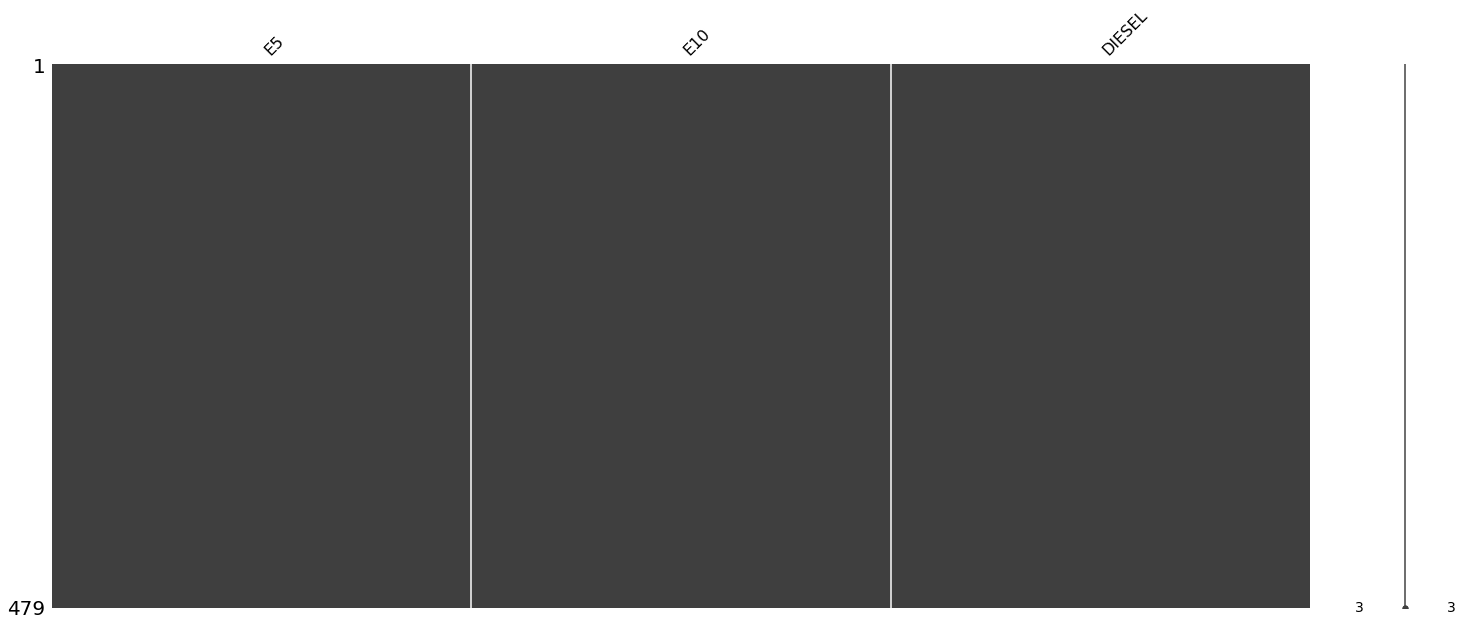

In [149]:
ms.matrix(selected_data)

In [150]:
selected_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 479 entries, 2014-06-08 to 2015-09-29
Data columns (total 3 columns):
E5        479 non-null float64
E10       479 non-null float64
DIESEL    479 non-null float64
dtypes: float64(3)
memory usage: 15.0+ KB


## Step 1: start with small (3 stations) data set and develop a simple reference model

In [52]:
def plot_expected_predicted(X_axis,expected,predicted):
    fig, ax = plt.subplots(figsize=(10,5))

    ax.xaxis.set_major_locator(plt.MaxNLocator(30))
    plt.xticks(rotation=90)

    ax.plot(X_axis, expected, label='Real Values')
    ax.plot(X_axis, predicted, label='Inferred values')
    ax.legend()
    #plt.xlabel('DAY OF THE YEAR')
    plt.xlabel('DATE')
    plt.ylabel('Price in EURO')

In [53]:
def movingaverage(values,window):
    return values.rolling(window=window,min_periods=1).mean()

In [93]:
def plot_TimeSeriesSplit_movAVG(values,window,n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    predictions = list()
    plt.figure(1)
    index = 1
    f, ax = plt.subplots(figsize=(10,8))
    
    ax.xaxis.set_major_locator(plt.MaxNLocator(30))
    plt.xticks(rotation=90)

    for train_index, test_index in tscv.split(values):
        small_train, small_test = values[train_index], values[test_index]
        small_train = movingaverage(small_train,window)
        plt.subplot(310 + index)
        plt.plot(small_train)
        plt.plot([None for i in small_train] + [x for x in small_test])
        index += 1
    plt.show()

In [80]:
small_data = pd.DataFrame()
for index, row in selected_st.head(3).iterrows():
        small_data = small_data.append(data[data['STID'].str.match(row['STID'])])

small_data = small_data[(small_data.HOUR >= 7)|(small_data.HOUR <= 20)]
small_data.reset_index(0,inplace= True)
small_data = small_data[['E5','E10','DIESEL','DATE_CHANGED']]
small_data['DATE_CHANGED'] = small_data['DATE_CHANGED'].apply(lambda x: x.strftime("%Y-%m-%d"))

In [81]:
small_data.head()

,E5,E10,DIESEL,DATE_CHANGED
0,1.319,1.279,1.179,2014-12-15
1,1.319,1.279,1.169,2014-12-15
2,1.319,1.259,1.169,2014-12-15
3,1.289,1.249,1.119,2014-12-16
4,1.279,1.239,1.119,2014-12-16


In [82]:
small_set = small_data.groupby(['DATE_CHANGED']).mean()
small_set.head()

,E5,E10,DIESEL
DATE_CHANGED,,,
2014-06-08,1.589000,1.549000,1.386500
2014-06-09,1.599476,1.559476,1.398524
2014-06-10,1.584172,1.544172,1.388655
2014-06-11,1.581059,1.541059,1.368118
2014-06-12,1.594455,1.554455,1.386273


In [83]:
model_movingAvg = small_set.copy()
#weekly window, 7 days
model_movingAvg['E5_infer'] = movingaverage(small_set['E5'],7)
model_movingAvg['E10_infer'] = movingaverage(small_set['E10'],7)
model_movingAvg['DIESEL_infer'] = movingaverage(small_set['DIESEL'],7)
model_movingAvg.head()


,E5,E10,DIESEL,E5_infer,E10_infer,DIESEL_infer
DATE_CHANGED,,,,,,
2014-06-08,1.589000,1.549000,1.386500,1.589000,1.549000,1.386500
2014-06-09,1.599476,1.559476,1.398524,1.594238,1.554238,1.392512
2014-06-10,1.584172,1.544172,1.388655,1.590883,1.550883,1.391226
2014-06-11,1.581059,1.541059,1.368118,1.588427,1.548427,1.385449
2014-06-12,1.594455,1.554455,1.386273,1.589632,1.549632,1.385614


In [84]:
model_movingAvg.dropna(inplace=True)
model_movingAvg = model_movingAvg.reset_index()

#### Prediction of E5 with moving average

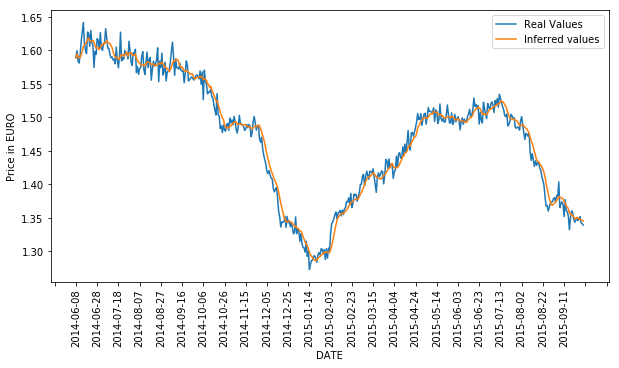

In [86]:
plot_expected_predicted(model_movingAvg['DATE_CHANGED'],model_movingAvg['E5'],model_movingAvg['E5_infer'])

#### Prediction of E10 with moving average

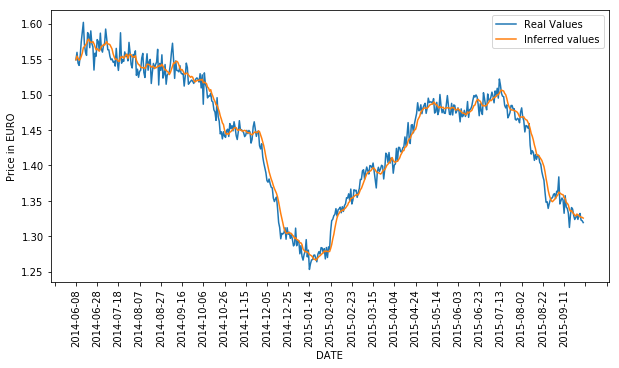

In [87]:
plot_expected_predicted(model_movingAvg['DATE_CHANGED'],model_movingAvg['E10'],model_movingAvg['E10_infer'])

#### Prediction of DIESEL with moving average

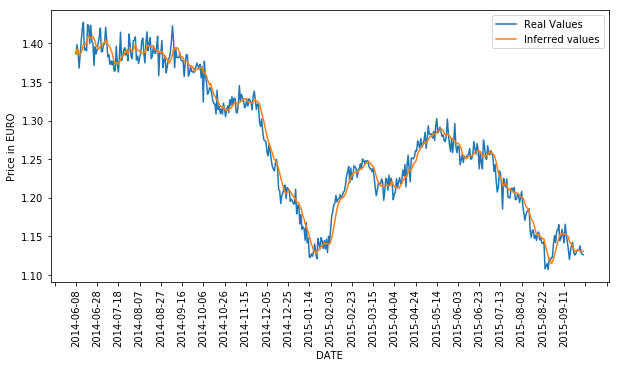

In [88]:
plot_expected_predicted(model_movingAvg['DATE_CHANGED'],model_movingAvg['DIESEL'],model_movingAvg['DIESEL_infer'])

### Time Series Cross validation of Moving average

#### E5 Time series Split with moving average


<Figure size 432x288 with 0 Axes>

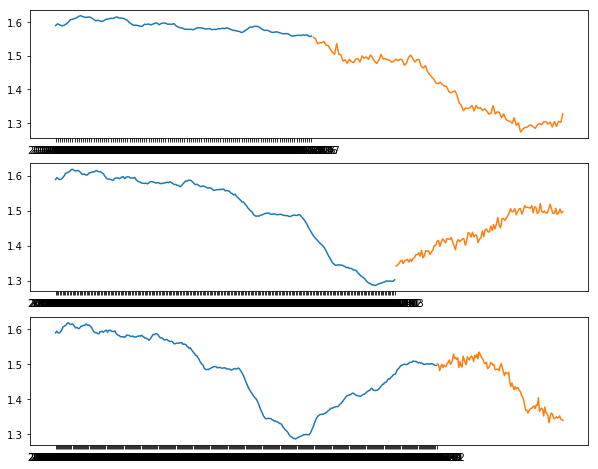

E10 Time series Split with moving average


<Figure size 432x288 with 0 Axes>

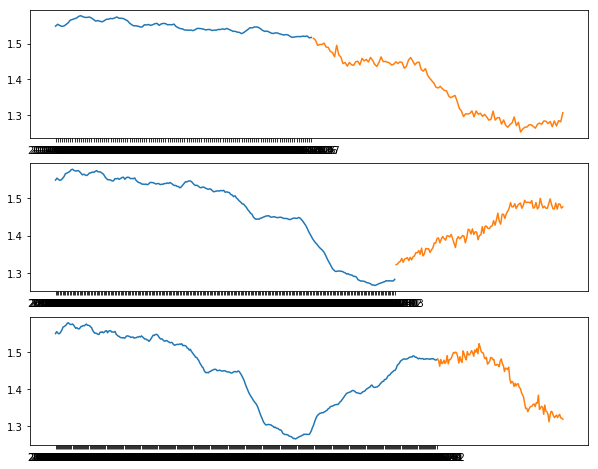

DIESEL Time series Split with moving average


<Figure size 432x288 with 0 Axes>

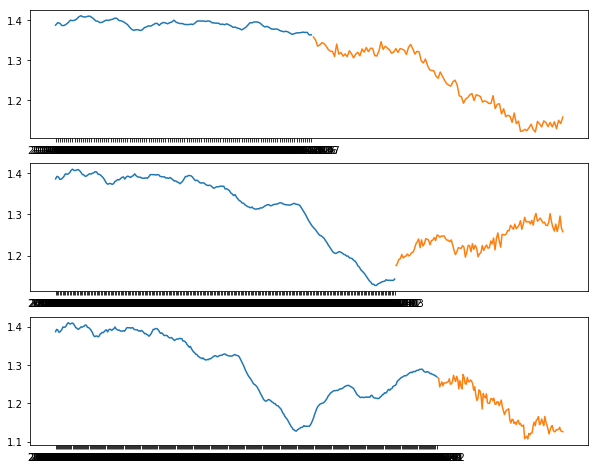

In [94]:
print("#### E5 Time series Split with moving average")
plot_TimeSeriesSplit_movAVG(small_set['E5'],7,3)
print("E10 Time series Split with moving average")
plot_TimeSeriesSplit_movAVG(small_set['E10'],7,3)
print("DIESEL Time series Split with moving average")
plot_TimeSeriesSplit_movAVG(small_set['DIESEL'],7,3)

## Step 2: go with a more complicated model, Facebook Prophet package

In [99]:
model_prophet = small_set.copy()
model_prophet.dropna(inplace=True)
model_prophet = model_prophet.reset_index()
prophet_e5 = model_prophet.rename(columns={'DATE_CHANGED': 'ds', 'E5': 'y'})
prophet_e5 = prophet_e5[['ds','y']]
prophet_e10 = model_prophet.rename(columns={'DATE_CHANGED': 'ds', 'E10': 'y'})
prophet_e10 = prophet_e10[['ds','y']]
prophet_diesel = model_prophet.rename(columns={'DATE_CHANGED': 'ds', 'DIESEL': 'y'})
prophet_diesel = prophet_diesel[['ds','y']]

In [141]:
def plot_TimeSeriesSplit_prophet(values,n_splits):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    predictions = pd.DataFrame()

    for train_index, test_index in tscv.split(values['y']):
        train, test = values['y'][train_index], values['y'][test_index]
        # Preparation to use prophet
        m = Prophet()
        m.fit(values[0:len(train)])
        future = m.make_future_dataframe(len(test))
        forecast = m.predict(future)
        fig1 = m.plot(forecast)

#### Time splits will be 3 for better visualization

### Predictions on E5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override th

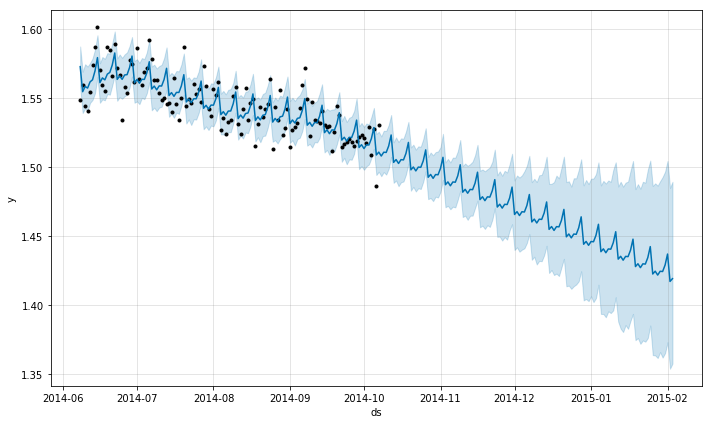

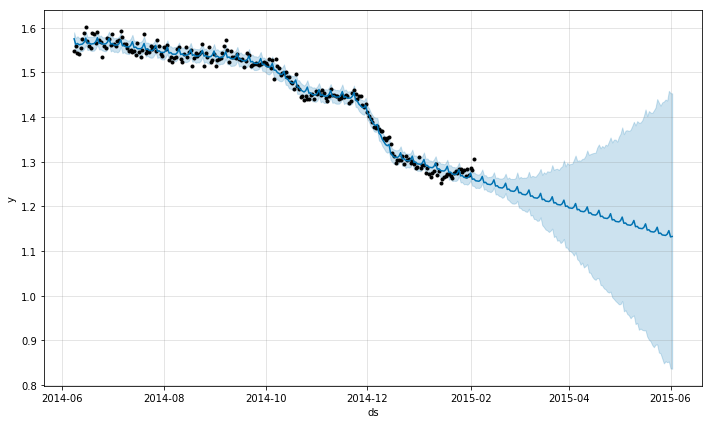

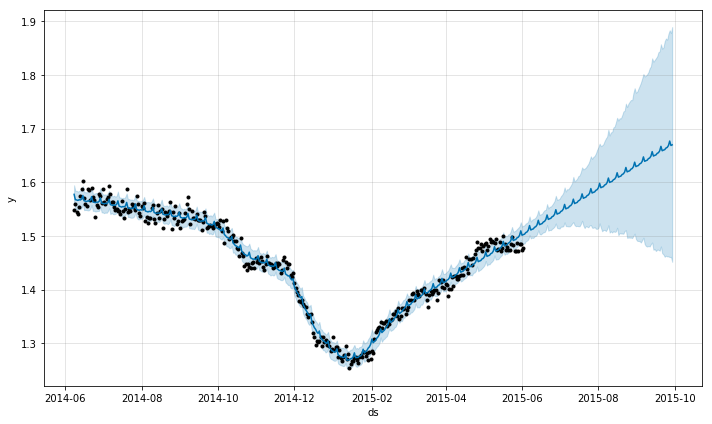

In [138]:
plot_TimeSeriesSplit_prophet(prophet_e10,3)

### Predictions on E10

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override th

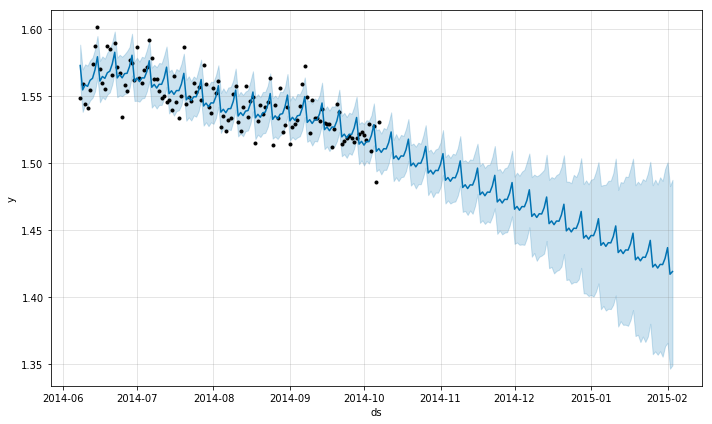

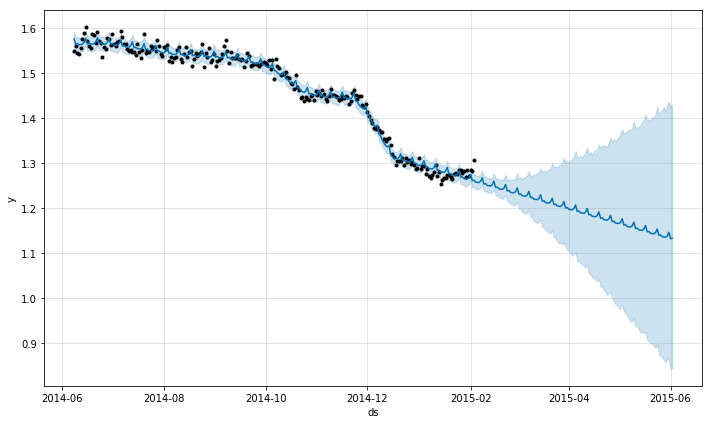

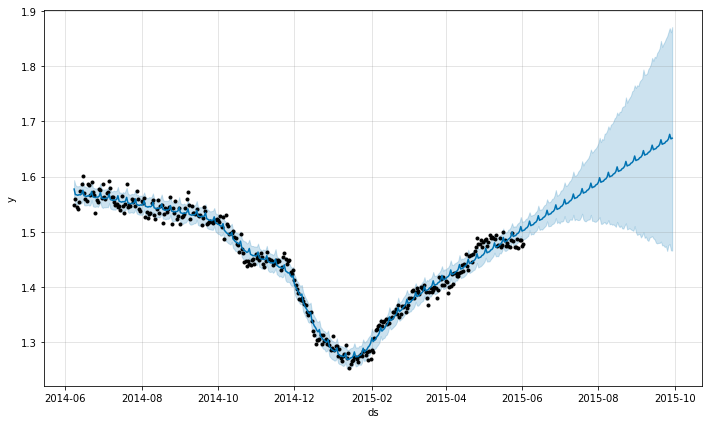

In [140]:
plot_TimeSeriesSplit_prophet(prophet_e10,3)

### Predictions on DIESEL

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override th

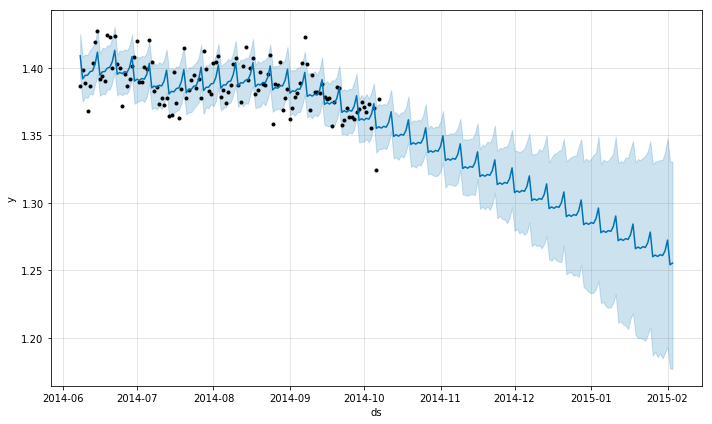

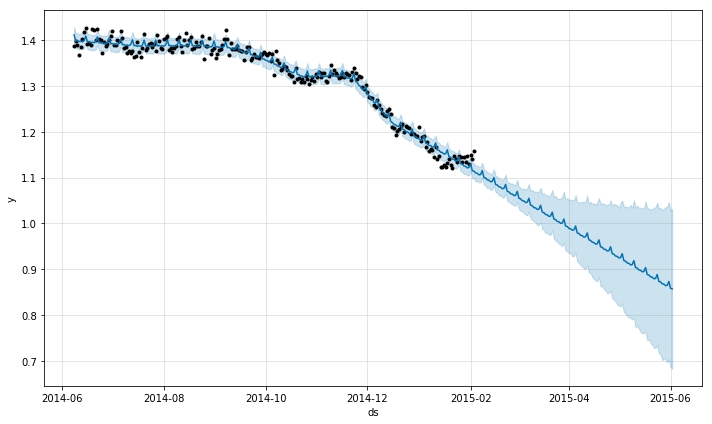

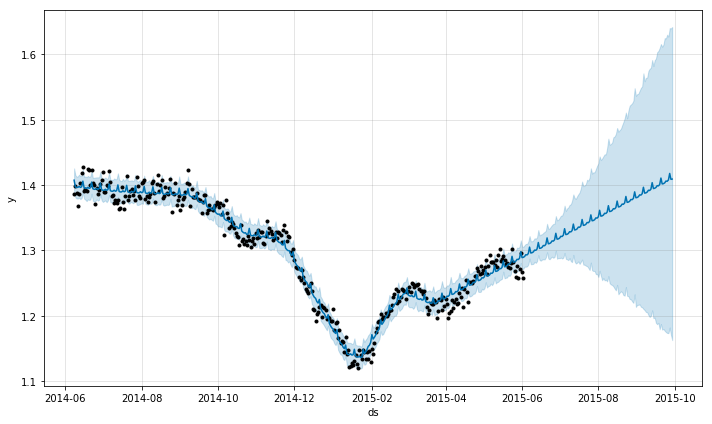

In [139]:
plot_TimeSeriesSplit_prophet(prophet_diesel,3)

## Step 3: full 100 data set for e5, e10 and diesel

In [154]:
full_prophet = selected_data.copy()
full_prophet.dropna(inplace=True)
full_prophet = full_prophet.reset_index()
prophet_e5_100 = full_prophet.rename(columns={'DATE_CHANGED': 'ds', 'E5': 'y'})
prophet_e5_100 = prophet_e5_100[['ds','y']]
prophet_e10_100 = full_prophet.rename(columns={'DATE_CHANGED': 'ds', 'E10': 'y'})
prophet_e10_100 = prophet_e10_100[['ds','y']]
prophet_diesel_100 = full_prophet.rename(columns={'DATE_CHANGED': 'ds', 'DIESEL': 'y'})
prophet_diesel_100 = prophet_diesel_100[['ds','y']]

### Predictions on E5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override th

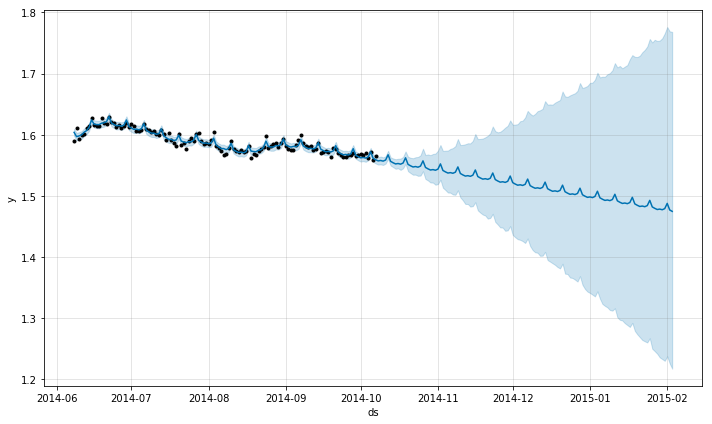

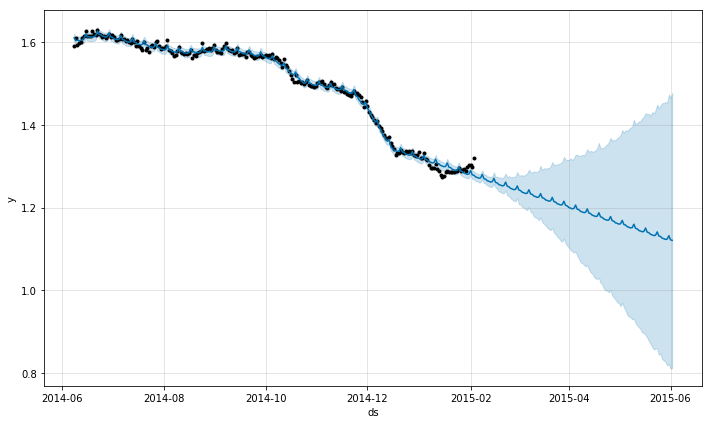

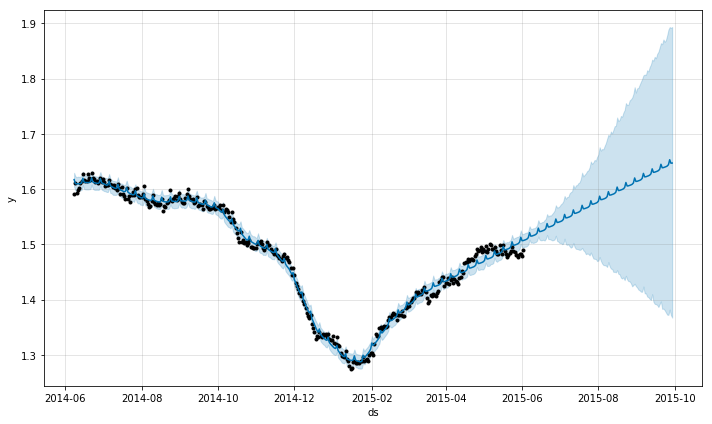

In [155]:
plot_TimeSeriesSplit_prophet(prophet_e5_100,3)

### Predictions on E10

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override th

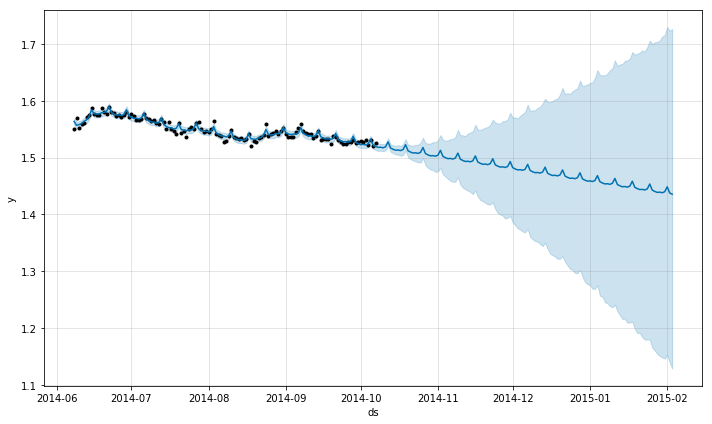

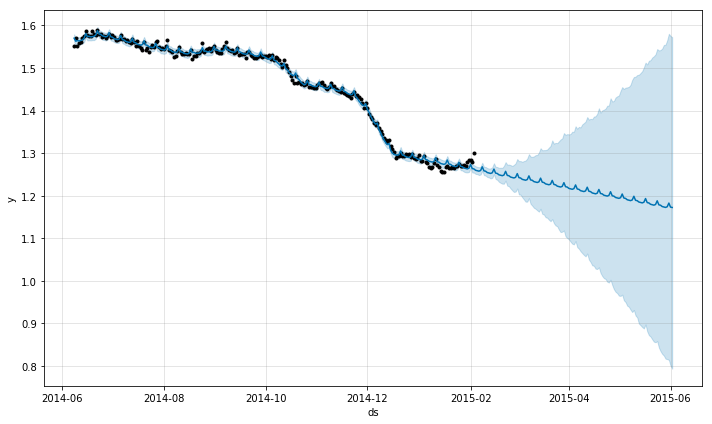

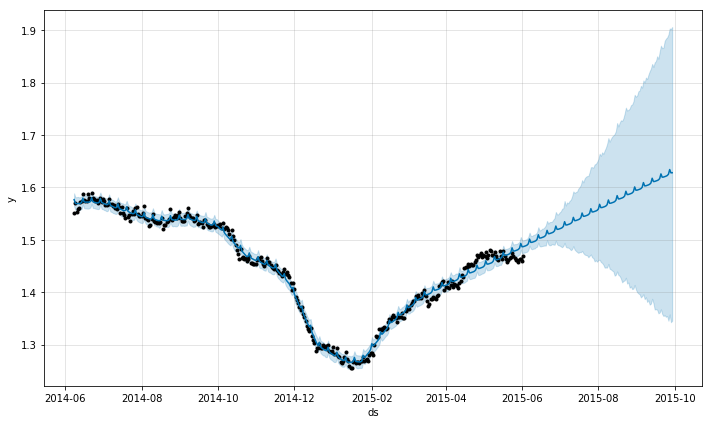

In [156]:
plot_TimeSeriesSplit_prophet(prophet_e10_100,3)

### Predictions on DIESEL

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override th

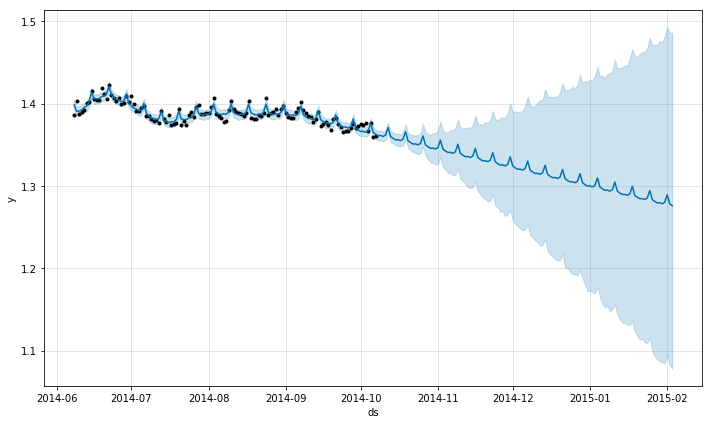

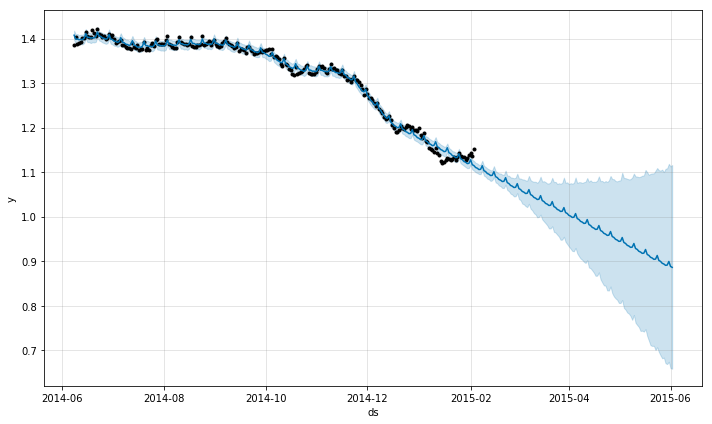

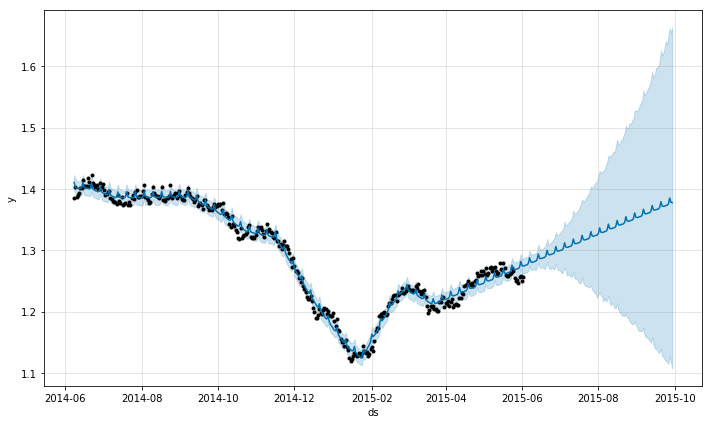

In [157]:
plot_TimeSeriesSplit_prophet(prophet_diesel_100,3)

## Unit Tests

In [158]:
class TestNotebook(unittest.TestCase):

    def test_matching_columns(self):
        d1 = {'col1': ["matchGARBAGE", "other","MatchGarbaGE"]}
        df1 = pd.DataFrame(data=d1)
        d2 = {'col1': ["MATCH", "other","MATCH"]}
        df2 = pd.DataFrame(data=d2)
        res = pd.testing.assert_frame_equal(ReplaceMatchingValue("match","MATCH",df1['col1']).to_frame(), df2)
        self.assertIsNone(res, msg=None)
    
    def test_date_columns_creation(self):
        d1 = {'date': [ '2014-10-02 05:22:01.000000']}
        df1 = pd.DataFrame(data=d1)
        df1['date'] =pd.to_datetime(df1.date)
        d2 = {'YEAR': [2014],'MONTH': [10], 'DAY':[2]}
        df2 = pd.DataFrame(data=d2)
        
        df1 = create_date_columns(df1,df1.date)
        res = pd.testing.assert_series_equal(df1['YEAR'], df2['YEAR'])
        self.assertIsNone(res, msg=None)
        res = pd.testing.assert_series_equal(df1['MONTH'], df2['MONTH'])
        self.assertIsNone(res, msg=None)

unittest.main(argv=[''], verbosity=2, exit=False)

test_date_columns_creation (__main__.TestNotebook) ... ok
test_matching_columns (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.188s

OK
